<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "MGC"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/MGC/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


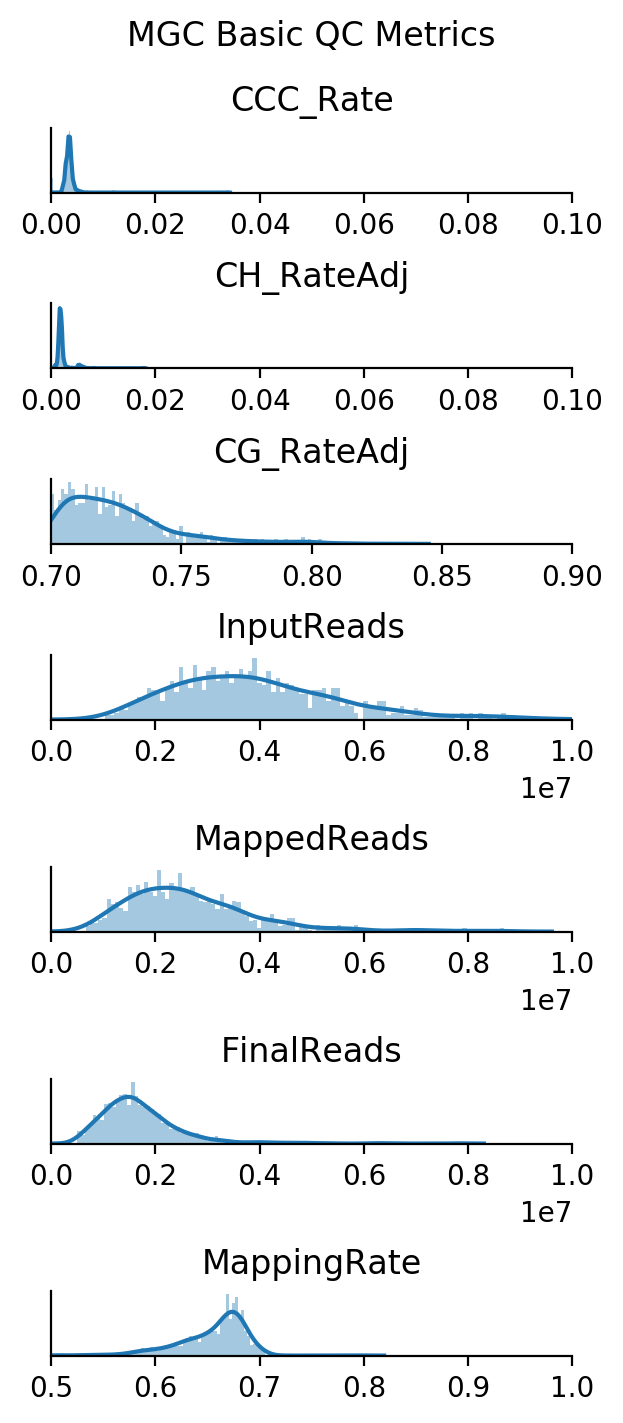

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

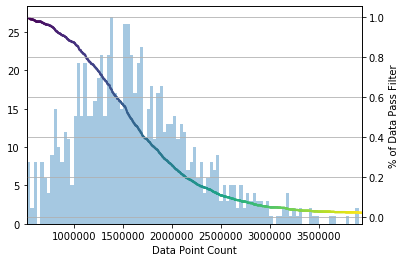

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 853/853 (100.0%)
CG_RateAdj passed 853/853 (100.0%)
CH_RateAdj passed 853/853 (100.0%)
FinalReads passed 853/853 (100.0%)
MappingRate passed 853/853 (100.0%)
Overall passed 853/853 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 8
171207 10
171212 3
171213 13
171214 6
171219 10
180104 2
180109 15
180110 9
180111 9
180119 23
180122 2
180123 9
180129 1
180130 7
180205 7
180206 9
180208 5
180212 5
180213 19
180220 10
180222 8
180226 6
180227 10
180305 8
180306 20
180312 2
180313 2
180319 2
180320 6
180326 5
180329 6
180402 2
180403 5
180405 3
180409 12
180410 11
180412 10
180416 10
180417 6
180419 17
180423 8
180424 5
180426 14
180430 9
180501 8
180514 9
180529 9
180806 3
180911 4
180917 4
180925 11
181002 9
181008 13
181009 19
181015 10
181016 12
181022 23
181023 19
181204 7
181206 18
181210 12
181218 9
181220 13
190108 15
190117 9
190122 17
190124 22
190131 8
190205 29
190207 7
190212 15
190214 33
190219 22
190305 26
190307 11
190625 6
190627 14
190711 24
190716 14


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 109 28.4%
ad002 100 26.0%
ad004 97 25.3%
ad006 100 26.0%
ad007 113 29.4%
ad008 105 27.3%
ad010 113 29.4%
ad012 116 30.2%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_1717,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003223,0.707143,0.706196,0.004983,0.001766,1843229.0,5646406,3536692.0,10E,...,-26.658749,4.511014,-43.531444,14.595268,MGC,-3.094986,2.006920,-2.507968,48.820055,True
10E_M_1724,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003822,0.750351,0.749393,0.005640,0.001826,1829910.0,5261164,3555111.0,10E,...,-26.214859,5.043328,-42.493299,15.774175,MGC,-1.380455,3.124240,-9.020122,41.970494,True
10E_M_1812,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003453,0.710305,0.709302,0.005279,0.001833,1644738.0,4439974,2874974.0,10E,...,-27.408382,4.637067,-44.933029,14.009831,MGC,-3.063549,1.562432,-1.009608,47.894164,True
10E_M_1822,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.004378,0.712854,0.711592,0.010608,0.006258,1147449.0,3615826,2201920.0,10E,...,-25.750549,5.065240,-41.742917,14.899331,MGC,-1.635344,3.727496,-10.863314,42.852456,True
10E_M_1901,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003354,0.698013,0.696997,0.005021,0.001673,1851507.0,5071650,3327483.0,10E,...,-26.989349,4.520205,-43.964733,13.934016,MGC,-3.578652,2.318818,-2.217633,51.833489,True
10E_M_1903,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003548,0.734873,0.733929,0.005433,0.001892,1818465.0,5066604,3211933.0,10E,...,-26.337564,4.853981,-42.763012,15.490801,MGC,-1.462042,2.767191,-7.337877,42.371067,True
10E_M_1994,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003376,0.689683,0.688631,0.005077,0.001706,1691000.0,4597810,2956383.0,10E,...,-27.783215,4.459774,-45.660316,13.347856,MGC,-4.572715,1.465653,0.596780,53.263616,True
10E_M_1998,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003735,0.742040,0.741073,0.005669,0.001942,2019592.0,5562038,3612664.0,10E,...,-26.029793,5.000836,-42.138609,15.828481,MGC,-1.141923,3.012567,-8.166235,41.076645,True
10E_M_212,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.003911,0.743003,0.741994,0.006055,0.002153,1455551.0,3631454,2364603.0,10E,...,-25.863029,5.052063,-42.027784,16.030291,MGC,-0.871978,3.129529,-8.968909,40.646601,True
